# Data Exploration Notebook

In [186]:
! pip install pandas_profiling[notebook,html]
! pip install matplotlib
! pip install nibabel
! pip install seaborn

## Lets look at the metadata

In [187]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
import seaborn as sns
import numpy as np

In [170]:
# Read the data
path_root = '/home/jovyan/'
data_folder = path_root + "data/"
stroke_meta_data = pd.read_excel(data_folder + '20171106_ATLAS_Meta-Data_Release_1.1_Updated.xlsx')

### Lets print the first few lines of the file and see whats what

In [171]:
stroke_meta_data.head()

,Unnamed: 0,Site ID,Subject ID,Organism,Organism Part,Developmental Stage,# Strokes LH Cortical,# Strokes LH subcortical,# Strokes RH Cortical,# Strokes RH subcortical,Other Location,Stroke type,Primary Stroke Location,Primary Stroke Location Hemisphere,Vascular territory,PVH,DWMH,Scanner Strength,Scanner Brand,Image Resolution
0,1,c0001,c0001s0004t01,Homo sapiens,Brain,Adult,0,1,0,0,0,Embolic/Hemorrhagic,"Basal ganglia, corona radiata",Left,Lacunar,1,0,1.5T,GE Signa,0.9 x 0.9 x 3.0 mm
1,2,c0001,c0001s0005t01,Homo sapiens,Brain,Adult,0,0,0,1,0,Embolic,"Basal ganglia, corona radiata",Right,Lacunar,3,2,1.5T,GE Signa,0.9 x 0.9 x 3.0 mm
2,3,c0001,c0001s0006t01,Homo sapiens,Brain,Adult,1,0,0,0,0,Embolic,Parietal lobe,Left,MCA,1,0,1.5T,GE Signa,0.9 x 0.9 x 3.0 mm
3,4,c0001,c0001s0007t01,Homo sapiens,Brain,Adult,0,0,1,0,0,Embolic,"Frontal, parietal lobes",Right,MCA,1,0,1.5T,GE Signa,0.9 x 0.9 x 3.0 mm
4,5,c0001,c0001s0008t01,Homo sapiens,Brain,Adult,0,1,1,0,0,Embolic,"Frontal lobe, basal ganglia, insula",Right,MCA,2,1,1.5T,GE Signa,0.9 x 0.9 x 3.0 mm


Lets generate a report looking at the raw data and see what is going on.

In [172]:
profile = ProfileReport(stroke_meta_data, title='Original Data Profiling Report', html={'style':{'full_width':True}})

In [174]:
profile.to_widgets()

Looking at this report we can see a few things:
   + Going to the warnings tab:
     + Subject ID is highly cardinal: 304 values
       + We have 304 different patients
     + Site ID, Scanner Strength, Scanner Brand, and Image Resolution are highly correlated with each other.
       + This makes sense because only a handful of scanners were used at specific sites running specific configurations. 
       + For our purposes we don't care about the scanners so we are going to drop these values. 
   + Looking at the Individual Variables
     + Unnamed: 0 has 304 unique values
       + Subject ID also has 304 unique values
       + We only need one unique key so lets drop Unnamed: 0
     + We can drop the following because there is only one value linked to them:
       + Organism: Homo sapiens
       + Organism Part: Brain
       + Developmental Stage: Adult
     + Need to do some cleaning on Stroke Type
       + We have Embolic and Emolic, the latter probably being a typo.
       + We have "Embolic/hemorrhagic", "Embolic/Hemorrhagic", and "Embolic or hemorrhagic", all of which describe the same thing.
     + Primary Stroke Location:
       + We have alot of different stroke locations (103 values). A closer look will be required to see what is going on. These could be errors in entering the data (ie. like in the stroke type section).
     + We will also want to reencode the data for some columns to make correlation analysis a bit easier for us to understand. 
       + Primary Stroke Location should correlate with Vascular Territory and Primary Stroke Location Hemisphere.

## Cleaning the data

#### Dropping Unnecessary Columns

In [127]:
stroke_meta_data.columns

Index(['Unnamed: 0', 'Site ID', 'Subject ID', 'Organism', 'Organism Part',
       'Developmental Stage', '# Strokes LH Cortical',
       '# Strokes LH subcortical', '# Strokes RH Cortical',
       '# Strokes RH subcortical', 'Other Location', 'Stroke type',
       'Primary Stroke Location', 'Primary Stroke Location Hemisphere',
       'Vascular territory', 'PVH', 'DWMH', 'Scanner Strength',
       'Scanner Brand', 'Image Resolution'],
      dtype='object')

In [128]:
cleaned_stroke_meta_data = stroke_meta_data.drop(['Unnamed: 0', 'Site ID', 'Organism', 'Organism Part', 'Developmental Stage', 'Scanner Strength', 'Scanner Brand', 'Image Resolution'], axis=1)

In [129]:
cleaned_stroke_meta_data.columns

Index(['Subject ID', '# Strokes LH Cortical', '# Strokes LH subcortical',
       '# Strokes RH Cortical', '# Strokes RH subcortical', 'Other Location',
       'Stroke type', 'Primary Stroke Location',
       'Primary Stroke Location Hemisphere', 'Vascular territory', 'PVH',
       'DWMH'],
      dtype='object')

#### Checking Data types

In [130]:
cleaned_stroke_meta_data.dtypes

Subject ID                            object
# Strokes LH Cortical                  int64
# Strokes LH subcortical               int64
# Strokes RH Cortical                  int64
# Strokes RH subcortical               int64
Other Location                         int64
Stroke type                           object
Primary Stroke Location               object
Primary Stroke Location Hemisphere    object
Vascular territory                    object
PVH                                    int64
DWMH                                   int64
dtype: object

#### Adding in total # of Strokes Column

In [190]:
def totalStrokes(row):
    return row['# Strokes LH Cortical'] + row['# Strokes LH subcortical'] + row['# Strokes RH Cortical'] + row['# Strokes RH subcortical'] + row['Other Location']

In [191]:
cleaned_stroke_meta_data['# Total Strokes'] = cleaned_stroke_meta_data.apply (lambda row: totalStrokes(row), axis=1)

#### Cleaning Stroke Type

In [192]:
# Fix the Emolic and Emoblic
cleaned_stroke_meta_data = cleaned_stroke_meta_data.replace('Emolic', 'Embolic')
cleaned_stroke_meta_data = cleaned_stroke_meta_data.replace('Emoblic', 'Embolic')

# Fix the Emoblic/hemmoragic and Embolic or hemmoragic
cleaned_stroke_meta_data = cleaned_stroke_meta_data.replace('Embolic/hemorrhagic', 'Embolic/Hemorrhagic')
cleaned_stroke_meta_data = cleaned_stroke_meta_data.replace('Embolic or hemorrhagic', 'Embolic/Hemorrhagic')

#### Cleaning the Primary Stroke Location

In [193]:
cleaned_stroke_meta_data['Primary Stroke Location'].unique()

array(['Basal ganglia, corona radiata', 'Parietal lobe',
       'Frontal, parietal lobes', 'Frontal lobe, basal ganglia, insula',
       'Frontal lobe, perirolandic region, basal gangial',
       'Basal ganglia, insula, internal capsule', 'Basal gangia',
       'Basal ganglia, internal capsule', 'Basal ganglia',
       'Frontal and parietal lobes, basal ganglia',
       'Frontal, temporal lobes', 'Frontal lobe',
       'Frontal, parietal, temporal lobes', 'Centrum semiovale', 'Pons',
       'Frontal lobe, basal ganglia',
       'Frontal lobe, basal ganglia, internal capsule',
       'Frontal lobe, basal ganglia, thalamus',
       'Frontal and parietal lobes, corpus callosum',
       'Frontal centrum semiovale, corona radiata',
       'Corona radiata, basal ganglia',
       'Basal ganglia, subinsular region', 'Corona radiata',
       'Interal capsule', 'Thalamus', 'Middle frontal gyrus',
       'Corona radiata, internal capsule',
       'Corona radiata, internal capsule, basal ganglia',

After the looking at the unique values in the table, it looks like this table is perfect to encode in to a column per value and add a 1 if it happened there and a 0. We should take a look at the number of unique values.

In [194]:
import re

def getUniqueSetForColumn(columnName, df):
    s = []
    for value in df[columnName].unique():
        locations = re.split(', |\. |/| and ', value)
        for l in locations:
            s.append(l.lower())
    return set(s)

In [195]:
s = getUniqueSetForColumn('Primary Stroke Location', cleaned_stroke_meta_data)
len(s)

60

In [196]:
s

{'basal gangia',
 'basal gangial',
 'basal ganglia',
 'basal ganglia.',
 'basal ganlia',
 'centrum semiovale',
 'cerebellum',
 'cerebral peduncle',
 'corona radiata',
 'corpus callosum',
 'deep parietal white matter',
 'frontal',
 'frontal centrum semiovale',
 'frontal corona radiata',
 'frontal lobe',
 'frontal lobe (inferior frontal gyrus)',
 'frontal lobe (precentral gyrus)',
 'frontal lobe centrum semiovale',
 'frontal operculum',
 'frontoparietal centrum semiovale',
 'head of left caudate',
 'insula',
 'interal capsule',
 'internal capsule',
 'left aspect of the midbrain',
 'left hemipons',
 'left precentral',
 'lentiform nucleus',
 'midbrain',
 'middle cerebral peduncle',
 'middle frontal gyrus',
 'occipital',
 'occipital lobe',
 'occipital lobes',
 'parietal',
 'parietal lobe',
 'parietal lobe (supramarginal gyrus)',
 'parietal lobes',
 'parietal lobes (perirolandic)',
 'parietal operculum',
 'parietooccipital region',
 'parietotemporal region',
 'perirolandic region',
 'pons',


Looking at the above we can make the following corrections:
+ basal gangia, basal gangial, basal ganglia, basal ganglia, basal ganlia are all the same. 
+ Frontal and all of its varients to frontal lobe
+ interal capsule and internal capsule
+ occiptal and all of its varients to occipital lobe
+ parietal and all of its varients to parietal loble
+ precentral gyrys and gyri to gyrus
+ temporal lobe to lobes
+ thalamus to thalamus

In [197]:
def returnCorrectedValue(val):
    if val == 'basal gangia' or val == 'basal gangial' or val == 'basal ganglia' or val == 'basal ganglia' or val == 'basal ganli' or val == 'basal ganglia.' or val == 'basal ganlia':
        return 'Basal Ganglia'
    if (val == 'frontal' or val == 'frontal lobe'):
        return 'Frontal Lobe'
    if val == 'frontal centrum semiovale' or val == 'frontoparietal centrum semiovale':
        return 'Frontal Centrum Semiovale'
    if val == 'interal capsule' or val == 'internal capsule':
        return 'Internal Capsule'
    if val == 'occipital' or val == 'occipital lobe' or val == 'occipital lobes':
        return 'Occipital Lobe'
    if val == 'parietal' or val == 'parietal lobe' or val == 'parietal lobes':
        return 'Parietal Lobe'
    if val == 'parietal lobes (perirolandic)' or val == 'perirolandic region':
        return 'Perirolandic Region'
    if val == 'postcentral gyri' or val == 'postcentral gyrus':
        return 'Postcentral Gyrus'
    if val == 'precentral' or val == 'precentral gyrus' or val == 'precentral gyrys' or val == 'frontal lobe (precentral gyrus)':
        return 'Precentral Gyrus'
    if val == 'subinsular region' or val == 'subinsular regions':
        return 'Subinsular Region'
    if val == 'superior frontal gyri' or val == 'superior frontal gyrus' or val == 'superior frontal gyrus.':
        return 'Superior Frontal Gyrus'
    if val == 'temporal lobe' or val == 'temporal lobes':
        return 'Temporal Lobe'
    if val == 'thalamus' or val == 'thalmus':
        return 'thalamus'
    
    return val;

In [198]:
normalized_stroke_meta_data = cleaned_stroke_meta_data.copy()

for index, row in normalized_stroke_meta_data.iterrows():
    loc = row['Primary Stroke Location']
    newLoc = []
    locations = re.split(', |\. |/| and ', loc)
    for l in locations:
        newLoc.append(returnCorrectedValue(l.lower()))
    
    newLoc.sort()
    normalized_stroke_meta_data.at[index, 'Primary Stroke Location'] = ', '.join(newLoc).lower()

In [199]:
s = getUniqueSetForColumn('Primary Stroke Location', normalized_stroke_meta_data)
len(s)

40

In [200]:
s

{'basal ganglia',
 'centrum semiovale',
 'cerebellum',
 'cerebral peduncle',
 'corona radiata',
 'corpus callosum',
 'deep parietal white matter',
 'frontal centrum semiovale',
 'frontal corona radiata',
 'frontal lobe',
 'frontal lobe (inferior frontal gyrus)',
 'frontal lobe centrum semiovale',
 'frontal operculum',
 'head of left caudate',
 'insula',
 'internal capsule',
 'left aspect of the midbrain',
 'left hemipons',
 'left precentral',
 'lentiform nucleus',
 'midbrain',
 'middle cerebral peduncle',
 'middle frontal gyrus',
 'occipital lobe',
 'parietal lobe',
 'parietal lobe (supramarginal gyrus)',
 'parietal operculum',
 'parietooccipital region',
 'parietotemporal region',
 'perirolandic region',
 'pons',
 'postcentral gyrus',
 'posterior limb internal capsule',
 'precentral gyrus',
 'right hemipons',
 'subinsular region',
 'superior frontal gyrus',
 'temporal lobe',
 'temporal operculum',
 'thalamus'}

This can probably be reduced even more, but we can take a look at that at a later time.

In [201]:
len(normalized_stroke_meta_data['Primary Stroke Location'].unique())

78

In [202]:
normalized_stroke_meta_data['Primary Stroke Location'].unique()

array(['basal ganglia, corona radiata', 'parietal lobe',
       'frontal lobe, parietal lobe',
       'basal ganglia, frontal lobe, insula',
       'basal ganglia, frontal lobe, perirolandic region',
       'basal ganglia, internal capsule, insula', 'basal ganglia',
       'basal ganglia, internal capsule',
       'basal ganglia, frontal lobe, parietal lobe',
       'frontal lobe, temporal lobe', 'frontal lobe',
       'frontal lobe, parietal lobe, temporal lobe', 'centrum semiovale',
       'pons', 'basal ganglia, frontal lobe',
       'basal ganglia, frontal lobe, internal capsule',
       'basal ganglia, frontal lobe, thalamus',
       'frontal lobe, parietal lobe, corpus callosum',
       'frontal centrum semiovale, corona radiata',
       'basal ganglia, subinsular region', 'corona radiata',
       'internal capsule', 'thalamus', 'middle frontal gyrus',
       'internal capsule, corona radiata',
       'basal ganglia, internal capsule, corona radiata',
       'internal capsule, th

In [203]:
def numLocations(row):
    return len(row['Primary Stroke Location'].split(', '))

In [204]:
normalized_stroke_meta_data['# of Locations'] = normalized_stroke_meta_data.apply (lambda row: numLocations(row), axis=1)

### Profile new data

In [205]:
normalized_stroke_meta_data.dtypes

Subject ID                            object
# Strokes LH Cortical                  int64
# Strokes LH subcortical               int64
# Strokes RH Cortical                  int64
# Strokes RH subcortical               int64
Other Location                         int64
Stroke type                           object
Primary Stroke Location               object
Primary Stroke Location Hemisphere    object
Vascular territory                    object
PVH                                    int64
DWMH                                   int64
# Total Strokes                        int64
# of Locations                         int64
dtype: object

In [206]:
profile = ProfileReport(normalized_stroke_meta_data, title='Original Data Profiling Report', html={'style':{'full_width':True}})

In [207]:
profile.to_widgets()

The Correlation plot above wasn't super useful, it wasn't taking the data types correctly. Let try it again...

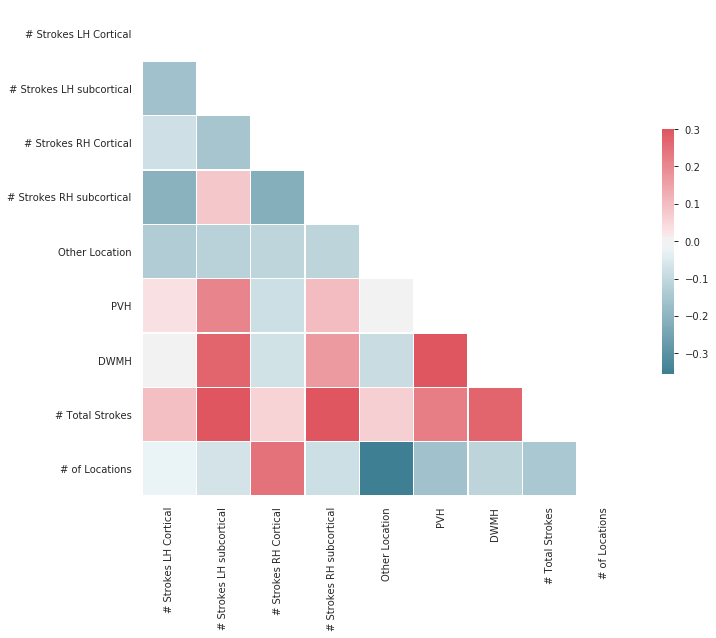

In [208]:
# Compute the correlation matrix
corr = normalized_stroke_meta_data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### Save the new Metadata frame
We will probably want to use this durring the training.

In [184]:
normalized_stroke_meta_data.to_pickle(data_folder + "normalized_data.pkl")

## Now lets look at a scan

In [216]:
import nibabel as nib
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [210]:
brain_scan_file_path = data_folder + 'native/native_1/c0001/c0001s0004t01/c0001s0004t01.nii.gz'
lesion_mask_file_path = data_folder + 'native/native_1/c0001/c0001s0004t01/c0001s0004t01_LesionSmooth.nii.gz'

In [221]:
brain_img = nib.load(brain_scan_file_path).get_fdata()

In [234]:
lesion_img = nib.load(lesion_mask_file_path).get_fdata()

In [213]:
brain_img.shape

(256, 256, 120)

In [214]:
lesion_img.shape

(256, 256, 120)

In [223]:
%matplotlib inline

In [238]:
def draw_brain_img(x):
    plt.imshow(brain_img[:,x,:])

In [240]:
interact(draw_brain_img, x=widgets.IntSlider(min=0, max=brain_img.shape[1] - 1, step=1, value=brain_img.shape[1]/2));

interactive(children=(IntSlider(value=128, description='x', max=255), Output()), _dom_classes=('widget-interac…

In [242]:
def draw_lesion_img(x):
    plt.imshow(lesion_img[:,x,:])

In [243]:
interact(draw_lesion_img, x=widgets.IntSlider(min=0, max=lesion_img.shape[1] - 1, step=1, value=lesion_img.shape[1]/2));

interactive(children=(IntSlider(value=128, description='x', max=255), Output()), _dom_classes=('widget-interac…

In [252]:
brain_scan_file_path = data_folder + 'native/native_1/c0004/c0004s0004t01/c0004s0004t01.nii.gz'
lesion_mask_file_path = data_folder + 'native/native_1/c0004/c0004s0004t01/c0004s0004t01_LesionSmooth.nii.gz'

In [253]:
brain_img = nib.load(brain_scan_file_path).get_fdata()
lesion_img = nib.load(lesion_mask_file_path).get_fdata()

In [254]:
brain_img.shape

(154, 197, 197)

In [255]:
lesion_img.shape

(154, 197, 197)

In [263]:
def draw_lesion_img(x):
    plt.imshow(lesion_img[:,:,x])

In [264]:
interact(draw_lesion_img, x=widgets.IntSlider(min=0, max=lesion_img.shape[1] - 1, step=1, value=lesion_img.shape[1]/2));

interactive(children=(IntSlider(value=98, description='x', max=196), Output()), _dom_classes=('widget-interact…

In [265]:
def draw_brain_img(x):
    plt.imshow(brain_img[:,:,x])


In [266]:
interact(draw_brain_img, x=widgets.IntSlider(min=0, max=brain_img.shape[2] - 1, step=1, value=brain_img.shape[2]/2));

interactive(children=(IntSlider(value=98, description='x', max=196), Output()), _dom_classes=('widget-interact…

We know the scans are coming in multiple formats and in multiple ways and sizes. We need to format them so that they are all one type and one size. I'm choosing to do a axial slicing of the patient and resize the image to 256x256 by either padding or cropping. I will need to do this twice, once for the brain image and once for the lesion mask. 

In [280]:
import os
import sys
def list_image_sizes_in_folder(path):
    output = [dI for dI in os.listdir(path) if os.path.isdir(os.path.join(path,dI))]
    for f in output:
        filePath = path + "/" + f + "/" + f + ".nii.gz"
        image_data = nib.load(filePath).get_fdata()
        print(image_data.shape)

In [285]:
list_image_sizes_in_folder(data_folder+"native/native_1/c0005")

(254, 208, 200)
(254, 208, 200)
(254, 208, 200)
(255, 208, 200)
(255, 208, 200)
(254, 205, 154)
(255, 208, 200)
(254, 208, 144)
(255, 208, 192)
(255, 208, 200)
(254, 208, 170)
(254, 208, 200)
(254, 208, 200)
(255, 208, 200)
(255, 208, 200)
(254, 208, 200)
(254, 201, 200)
(255, 208, 189)
(255, 208, 200)
(254, 204, 178)
(255, 208, 200)
(254, 206, 200)
(254, 208, 181)
(255, 208, 200)
(255, 203, 200)
(255, 206, 200)
(255, 208, 199)
(255, 208, 200)
(255, 208, 200)
(255, 208, 200)


In [400]:
import nilearn.image
def resampleTest(img):    
    # Now we need to calc the scale matrix.
    sizeMatrix = np.array([s[0]/256, s[1]/256, s[2]/256, 1])
    print(sizeMatrix)
    
    affineT = np.eye(4) * sizeMatrix
    affineT[0][3] = translation[0]
    affineT[1][3] = translation[1]
    affineT[2][3] = translation[2]
    print(affineT)
    
    #nilearn.image.resample(img, )
    return nilearn.image.resample_img(img, img.affine * sizeMatrix, (256, 256, 256))

In [401]:
brain_img = nib.load(brain_scan_file_path)

In [402]:
resampled_brain_image = resampleTest(brain_img)

[51.  29.5 29.5  0. ]
[0.6015625  0.76953125 0.76953125 1.        ]
[[ 0.6015625   0.          0.         51.        ]
 [ 0.          0.76953125  0.         29.5       ]
 [ 0.          0.          0.76953125 29.5       ]
 [ 0.          0.          0.          1.        ]]


In [403]:
resampled_brain_image.shape

(256, 256, 256)

In [404]:
brain_img.shape

(154, 197, 197)

In [405]:
def draw_brain_img(x):
    d = resampled_brain_image.get_fdata()
    plt.imshow(d[:,:,x])

In [406]:
interact(draw_brain_img, x=widgets.IntSlider(min=0, max=resampled_brain_image.shape[2] - 1, step=1, value=resampled_brain_image.shape[2]/2));

interactive(children=(IntSlider(value=128, description='x', max=255), Output()), _dom_classes=('widget-interac…